# Práctico 2
- Levantar los datos desde el archivo dataset/demanda.csv. Los mismos fueron extraídos de los datos del informe mensual en http://portalweb.cammesa.com/memnet1/Pages/descargas.aspx
- Explorar los datos y visualizar descomposición de datos.
- Modelar con Holt Winters Smoothing con diferentes parámetros.
- Visualizar los resultados y evaluar su poder predictivo, comparando ambos modelos.

In [44]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
from plotting import fanchart

In [45]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [63]:
df = pd.read_csv('./datasets/demanda.csv',
                 dtype={'Año':str,'Trimestre':str},
                 index_col = 'TIPO',
                 parse_dates = True, 
                 dayfirst = True)
df.head()

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
TIPO,,,,
2013-01-01,4538446.146,3319300.732,3276372.467,1.113412e+07
2013-02-01,3961686.119,2820263.212,3052210.676,9.834160e+06
2013-03-01,3612835.111,2861328.931,3281965.266,9.756129e+06
2013-04-01,3239380.702,2826797.310,3241156.151,9.307334e+06
2013-05-01,3919668.996,2948663.278,3364493.120,1.023283e+07


In [64]:
y = df['TOTAL'].copy()
y.index = y.index.to_period(freq='M')
ts = df['TOTAL']

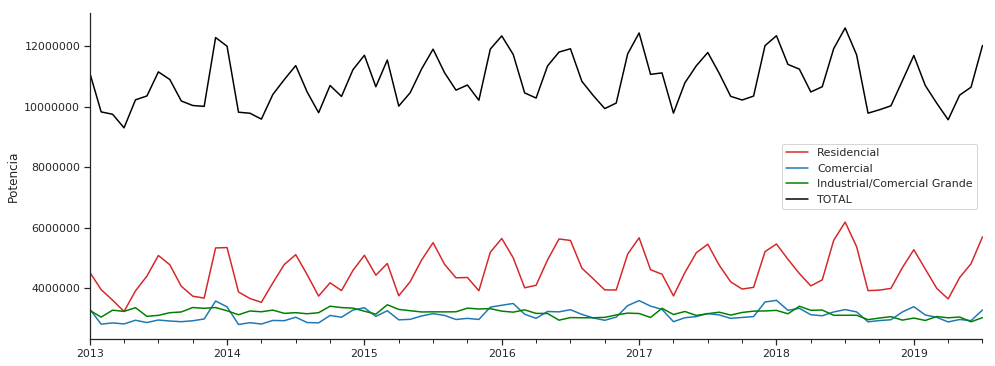

In [65]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.ticklabel_format(style = 'plain')
df['Residencial'].plot(color = red, 
                       label = 'Residencial')
df['Comercial'].plot(color = blue, 
                     label = 'Comercial')
df['Industrial/Comercial Grande'].plot(color = 'green', 
                                       label = 'Industrial/Comercial Grande')
df['TOTAL'].plot(color = 'black', label = 'TOTAL')
ax.set_xlabel('')
ax.set_ylabel('Potencia')
plt.legend(loc = 'best')

sns.despine()
plt.show()

In [66]:
print(ts.describe().round(2))

count          79.00
mean     10853008.74
std        816874.81
min       9307334.16
25%      10223259.40
50%      10706955.32
75%      11476364.98
max      12607552.72
Name: TOTAL, dtype: float64


### Descomposición

In [68]:
decomposition = sm.tsa.x13_arima_analysis(ts.astype(float), x12path = './x13asall_V1.1_B39/')
[attr for attr in dir(decomposition) if not attr.startswith('_')]

['irregular', 'observed', 'plot', 'results', 'seasadj', 'stdout', 'trend']

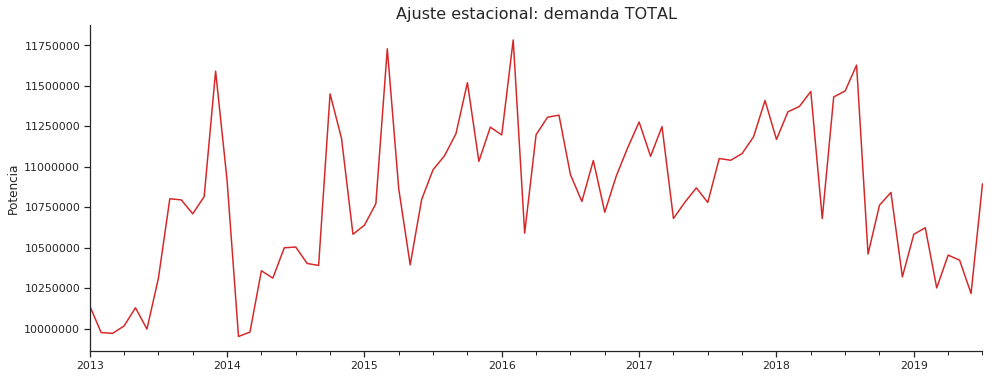

In [69]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.ticklabel_format(style = 'plain')
decomposition.seasadj.plot(color = red)
ax.set_xlabel('')
ax.set_ylabel('Potencia')
ax.set_title('Ajuste estacional: demanda TOTAL', fontsize = 16)
sns.despine()
plt.show()

###### Descomponiendo

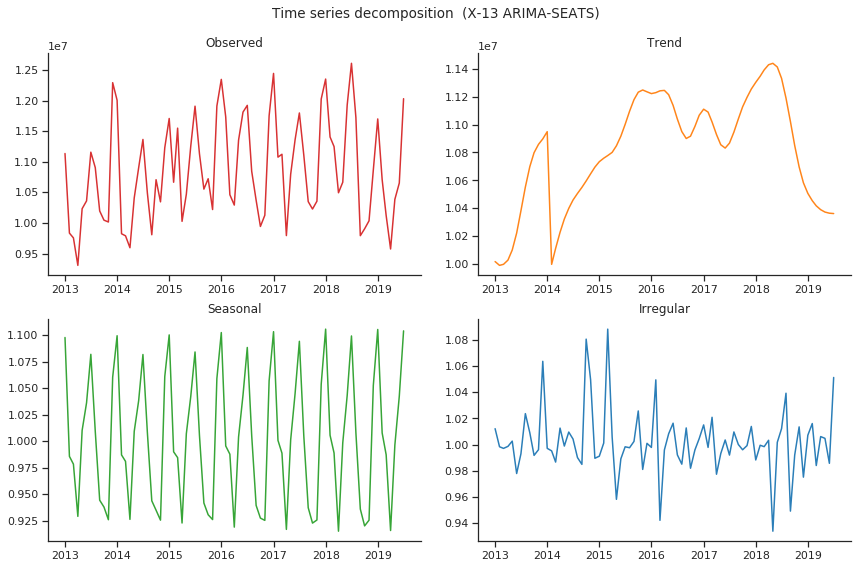

In [70]:
from plotting import plot_components_x13
plot_components_x13(decomposition)
plt.show()

In [71]:
z = decomposition.seasadj.copy()
z.index = ts.index.to_period(freq = 'M')

model_sm = sm.tsa.Holt(z).fit()
smoothed_sm = model_sm.fittedvalues
alpha_sm = model_sm.model.params['smoothing_level']
betha_sm = model_sm.model.params['smoothing_slope']
mse_sm = sm.tools.eval_measures.mse(ts,smoothed_sm)

print(' Smoothing parameter: alpha  {0:.3f}'.format(alpha_sm))
print(' Smoothing parameter: betha  {0:.3f}'.format(betha_sm))
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_sm))

model_sm.summary()

 Smoothing parameter: alpha  0.384
 Smoothing parameter: betha  0.000
 In-sample fit:
 MSE               608473512336.229


Dep. Variable:,endog,No. Observations:,79
Model:,Holt,SSE,11014744899648.361
Optimized:,True,AIC,2035.204
Trend:,Additive,BIC,2044.682
Seasonal:,None,AICC,2036.371
Seasonal Periods:,None,Date:,"Mon, 30 Sep 2019"
Box-Cox:,False,Time:,21:31:59
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3844672,alpha,True
smoothing_slope,0.000000,beta,True


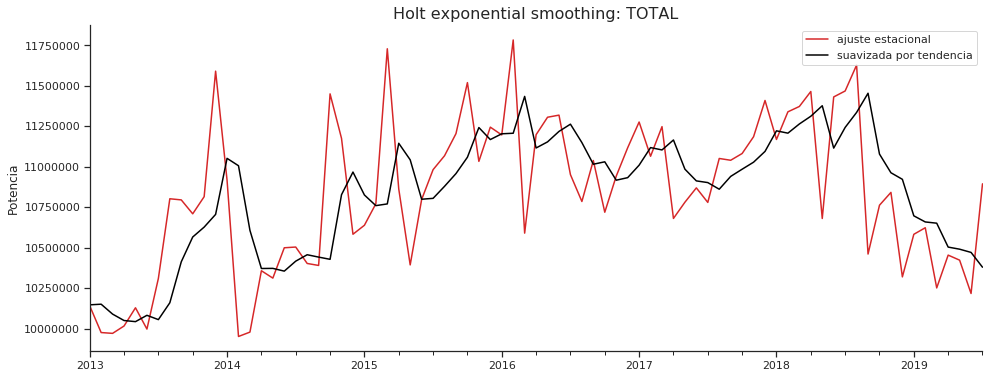

In [74]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.ticklabel_format(style = 'plain')

ax.set_title('Holt exponential smoothing: TOTAL', fontsize = 16)

z.plot(color = '#D62728', label = 'ajuste estacional')
smoothed_sm.plot(color = 'black', label = 'suavizada por tendencia')

plt.legend(loc = 'best')
ax.set_xlabel('')
ax.set_ylabel('Potencia')

sns.despine()
plt.show()

###### Rolling y espanding windows

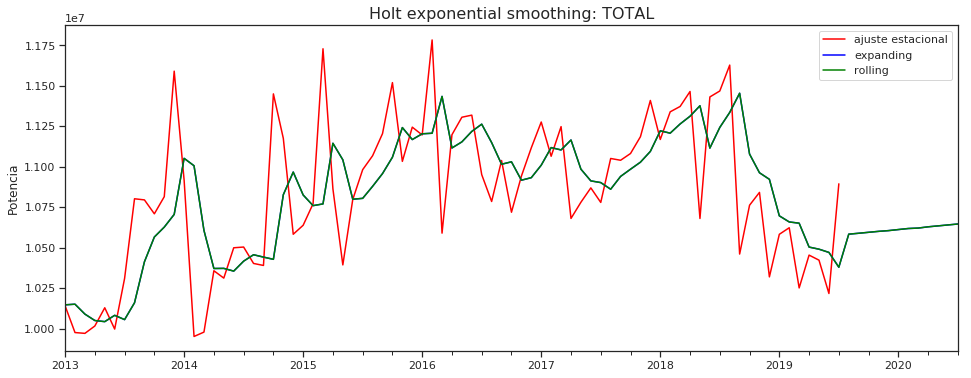

In [76]:
h = 12
w = h * 12
Z = z

model = sm.tsa.Holt
pred_index = Z.index[-1] + np.array(range(1, h + 1))
pred_rolling = pd.Series(0, index = pred_index)
pred_expanding = pd.Series(0, index = pred_index)
orig_fit = None

for i in range(0, h):
    current = pd.concat([Z, pred_expanding.head(i)])
    expanding = model(current).fit()
    if i == 0:
        orig_fit = expanding.fittedvalues
        
    rolling = model(current.tail(w)).fit()
    pred_expanding.update(expanding.forecast(1))
    pred_rolling.update(rolling.forecast(1))
    
ax = Z[-w:].plot(color = 'red', figsize = (16, 6), label = 'ajuste estacional')
ax.set_title('Holt exponential smoothing: TOTAL', fontsize = 16)
ax.set_xlabel('')
ax.set_ylabel('Potencia')

pd.concat([orig_fit[-w:], pred_expanding]).plot(ax = ax, color = 'blue', label = 'expanding')
pd.concat([orig_fit[-w:], pred_rolling]).plot(ax = ax, color = 'green', label = 'rolling')

plt.legend(loc = 'best')
plt.show()

#### Holt Winters Smoothing

In [80]:
def hw_summary(model_sm):
    rmse_sm = sm.tools.eval_measures.rmse(model_sm.data.endog,model_sm.fittedvalues)
    print(' In-sample fit:')
    print(' RMSE               {0:.3f}'.format(rmse_sm))
    return model_sm.summary()

In [94]:
mhw_sm = sm.tsa.ExponentialSmoothing(y,
                                     trend = 'add',
                                     damped = False, 
                                     seasonal = 'mul', 
                                     seasonal_periods = 12).fit()
hw_summary(mhw_sm)

 In-sample fit:
 RMSE               373386.185


Dep. Variable:,endog,No. Observations:,79
Model:,ExponentialSmoothing,SSE,11013962221359.184
Optimized:,True,AIC,2059.198
Trend:,Additive,BIC,2097.109
Seasonal:,Multiplicative,AICC,2070.598
Seasonal Periods:,12,Date:,"Mon, 30 Sep 2019"
Box-Cox:,False,Time:,21:41:51
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3555771,alpha,True
smoothing_slope,1.1235e-13,beta,True


In [84]:
ahw_sm = sm.tsa.ExponentialSmoothing(y, 
                                     trend = 'add',
                                     damped = False, 
                                     seasonal = 'mul', 
                                     seasonal_periods = 12).fit()
hw_summary(ahw_sm)

 In-sample fit:
 RMSE               373386.185


Dep. Variable:,endog,No. Observations:,79
Model:,ExponentialSmoothing,SSE,11013962221359.184
Optimized:,True,AIC,2059.198
Trend:,Additive,BIC,2097.109
Seasonal:,Multiplicative,AICC,2070.598
Seasonal Periods:,12,Date:,"Mon, 30 Sep 2019"
Box-Cox:,False,Time:,21:37:33
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3555771,alpha,True
smoothing_slope,1.1235e-13,beta,True


In [85]:
mhw_damped=sm.tsa.ExponentialSmoothing(y, 
                                       trend='add', 
                                       damped=True, 
                                       seasonal='mul',
                                       seasonal_periods=12).fit()
hw_summary(mhw_damped)

 In-sample fit:
 RMSE               373992.563


Dep. Variable:,endog,No. Observations:,79
Model:,ExponentialSmoothing,SSE,11049764539949.244
Optimized:,True,AIC,2061.455
Trend:,Additive,BIC,2101.735
Seasonal:,Multiplicative,AICC,2074.336
Seasonal Periods:,12,Date:,"Mon, 30 Sep 2019"
Box-Cox:,False,Time:,21:37:44
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3601599,alpha,True
smoothing_slope,0.0526472,beta,True


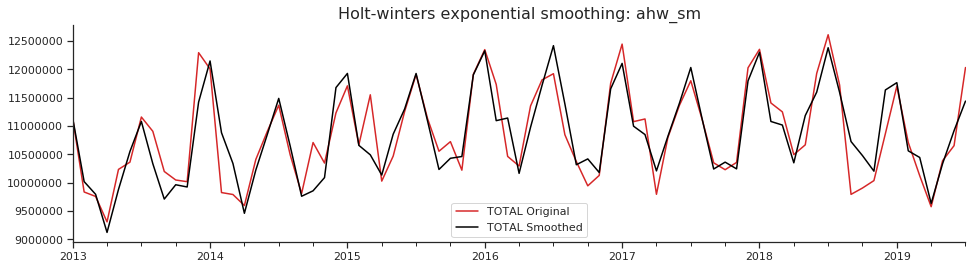

In [92]:
smoothed = pd.Series(ahw_sm.fittedvalues, 
                    index = y.index)

fig, ax = plt.subplots(figsize = (16, 4))
plt.ticklabel_format(style = 'plain')

y.plot(color = '#D62728',
                 label = 'TOTAL Original')
smoothed.plot(color = 'black', 
              label = 'TOTAL Smoothed')

plt.legend(loc = 'best')
ax.set_xlabel('')
ax.set_title('Holt-winters exponential smoothing: ahw_sm', fontsize = 16)
 
sns.despine()
plt.show()

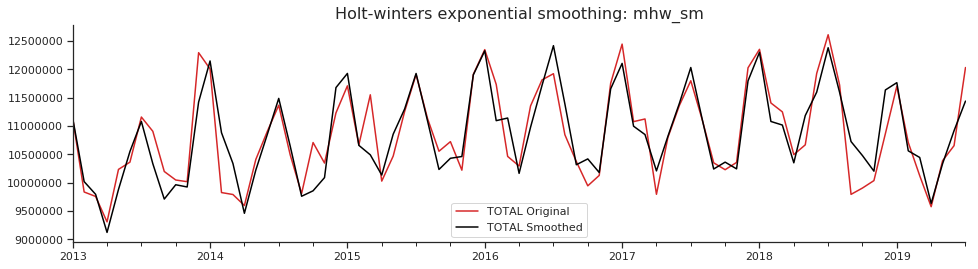

In [95]:
smoothed = pd.Series(mhw_sm.fittedvalues, 
                    index = y.index)

fig, ax = plt.subplots(figsize = (16, 4))
plt.ticklabel_format(style = 'plain')

y.plot(color = '#D62728',
                 label = 'TOTAL Original')
smoothed.plot(color = 'black', 
              label = 'TOTAL Smoothed')

plt.legend(loc = 'best')
ax.set_xlabel('')
ax.set_title('Holt-winters exponential smoothing: mhw_sm', fontsize = 16)
 
sns.despine()
plt.show()

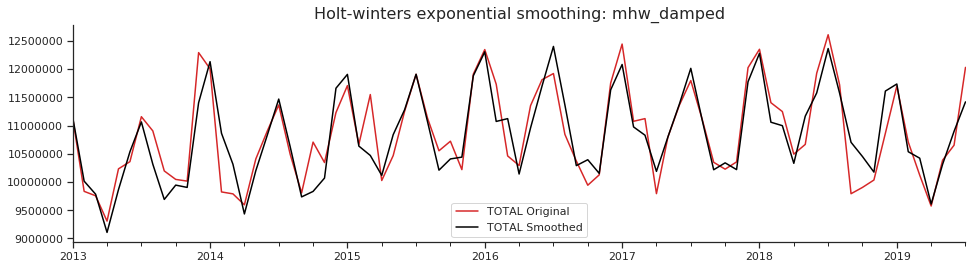

In [96]:
smoothed = pd.Series(mhw_damped.fittedvalues, 
                    index = y.index)

fig, ax = plt.subplots(figsize = (16, 4))
plt.ticklabel_format(style = 'plain')

y.plot(color = '#D62728',
                 label = 'TOTAL Original')
smoothed.plot(color = 'black', 
              label = 'TOTAL Smoothed')

plt.legend(loc = 'best')
ax.set_xlabel('')
ax.set_title('Holt-winters exponential smoothing: mhw_damped', fontsize = 16)
 
sns.despine()
plt.show()

#### Diagnóstico del modelo

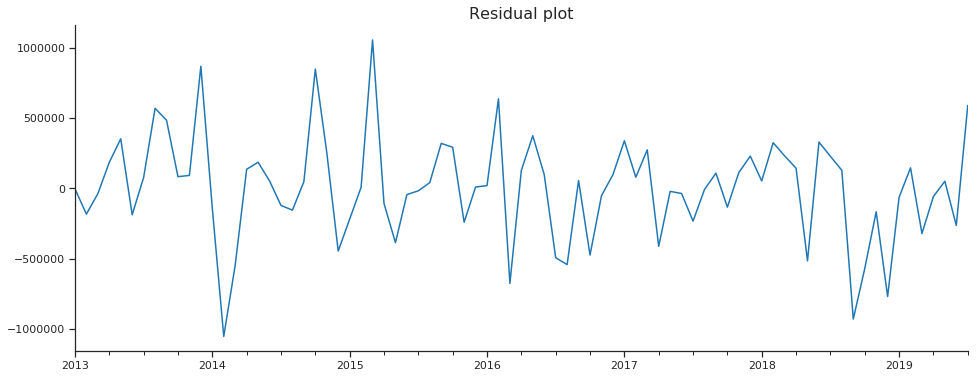

In [97]:
resid = (y - mhw_sm.fittedvalues)

fig, ax = plt.subplots(figsize = (16, 6))
resid.plot(color = blue)
ax.set_xlabel('')
ax.set_title('Residual plot', fontsize = 16)

sns.despine()
plt.show()

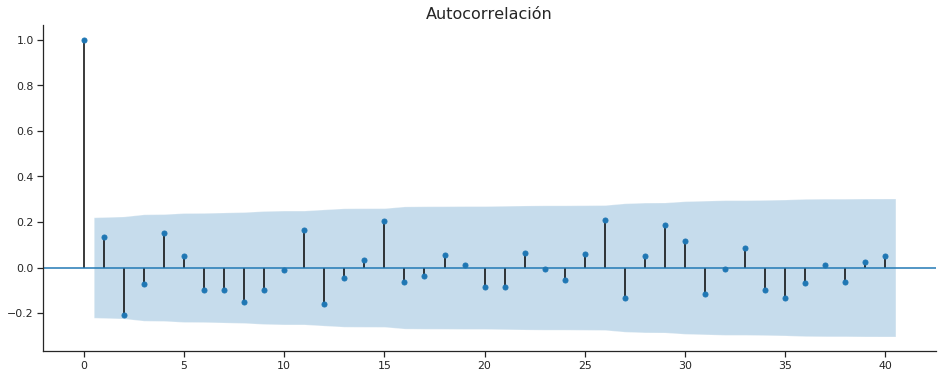

In [98]:
fig, ax = plt.subplots(figsize = (16, 6))

sm.graphics.tsa.plot_acf(resid, lags = 40, ax = ax)
ax.set_title('Autocorrelación', fontsize = 16)

sns.despine()
plt.show()

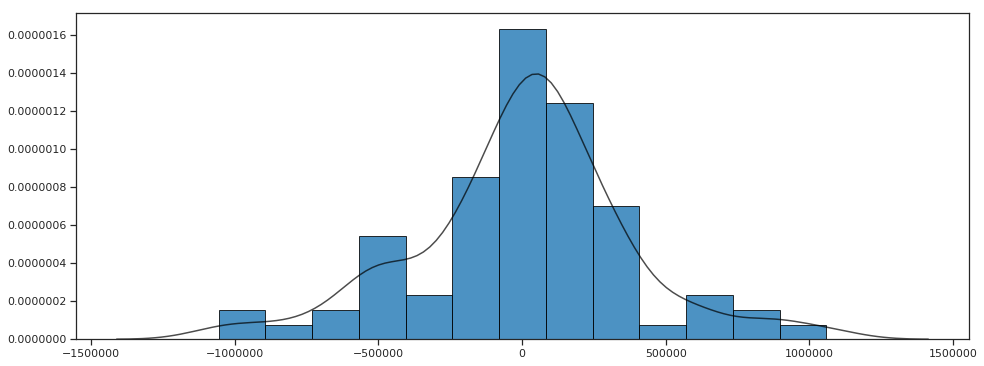

In [99]:
from plotting import histogram

fig, ax = plt.subplots(figsize = (16, 6))
    
sns.distplot(resid, ax = ax, hist_kws = {'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws = {'color': 'black', 'alpha': 0.7})

plt.show()

#### Validacion

In [101]:
start_val = y.index[-round(len(y) / 12 * .2) * 12]
start_val

Period('2018-08', 'M')

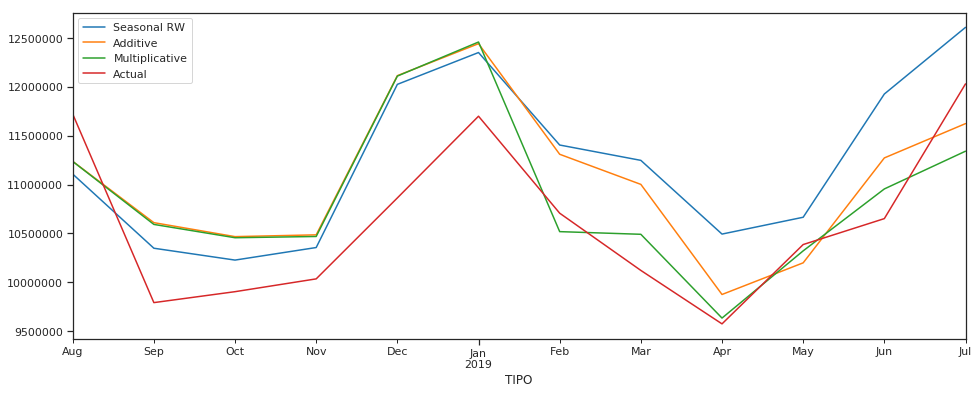

In [105]:
validation = y[start_val:].index
start = y.index.get_loc(start_val) 

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
pred3 = [] # multiplicative holt winters
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i])
    
    pred1.append(y.iloc[i-12])
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], 
                                        trend = 'add', 
                                        damped = False, 
                                        seasonal = 'add', 
                                        seasonal_periods = 12).fit()
    pred2.append(model.forecast(1)[0])
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], 
                                        trend = 'add', 
                                        damped = False, 
                                        seasonal = 'mul',
                                        seasonal_periods = 12).fit()
    pred3.append(model.forecast(1)[0])
    

columns = ['Seasonal RW', 'Additive', 'Multiplicative', 'Actual']
results = np.vstack([pred1, pred2, pred3, actual]).T
results = pd.DataFrame(results, columns = columns, index = validation)

fig, ax = plt.subplots(figsize = (16, 6))
plt.ticklabel_format(style = 'plain')

results.plot(ax = ax)

plt.show()

In [106]:
from scipy import stats

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(len(results.columns)-1):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results.iloc[:,i], results.iloc[:,-1])
    table.iloc[i,1] = (results.iloc[:,i] - results.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
Seasonal RW,779964.344,148054.667
Additive,667736.842,154236.596
Multiplicative,594543.350,161500.128


#### Forecast

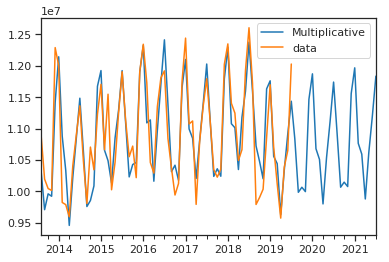

In [107]:
h=2*12 #M
w=h*3

model = sm.tsa.ExponentialSmoothing(y,
                                    trend='add',
                                    damped=False, 
                                    seasonal='mul',
                                    seasonal_periods=12).fit()

plot = pd.DataFrame()
plot['Multiplicative'] = pd.concat([model.fittedvalues, model.forecast(h)])
plot['data'] = y

plot[-(w+h):].plot();#figsize=(9,6))

###### Desvíos

In [17]:
resid_total = df['total'] - df['total'].shift(1)
sigma_total = resid_total.std()
desv_total = round(sigma_total, 3)

print('\
Desvío total:\t{}\n\
'.format(desv_total))

Desvío total:	1409600.295



###### Intervalos de confianza

In [19]:
intv_total = pd.concat([pred_total - stats.norm.ppf(0.975) * sigma_total * np.sqrt(np.arange(1, h + 1)),
                        pred_total + stats.norm.ppf(0.975) * sigma_total * np.sqrt(np.arange(1, h + 1))],
                       axis = 1).round(3)
print('\
Intervalo total:\t{}\n\n\
'.format(intv_pospago))

Intervalo total:	                   0             1
2019Q2  1.175970e+07  1.611484e+07
2019Q3  1.085772e+07  1.701682e+07
2019Q4  1.016560e+07  1.770894e+07
2020Q1  9.582125e+06  1.829242e+07




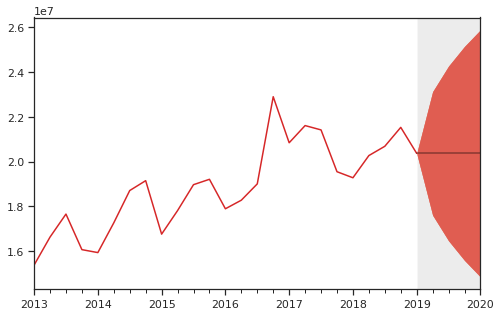

In [20]:
point_pred = (intv_total[0]+intv_total[1])/2
fig, ax = fanchart(df['total'],
                   point_pred,
                   intv_total,
                   intv_total,
                   intv_total)
plt.show()

##### Simple exponential smoothing

In [24]:
model_ses = sm.tsa.SimpleExpSmoothing(df['total'].astype(np.float)).fit()
fitted_ses = model_ses.fittedvalues
model_ses.summary()

Dep. Variable:,endog,No. Observations:,25
Model:,SimpleExpSmoothing,SSE,43486319814188.438
Optimized:,True,AIC,708.615
Trend:,None,BIC,711.053
Seasonal:,None,AICC,710.615
Seasonal Periods:,None,Date:,"Mon, 30 Sep 2019"
Box-Cox:,False,Time:,20:42:04
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5589059,alpha,True
initial_level,1.5819e+07,l.0,True


In [25]:
mse_ses = sm.tools.eval_measures.mse(df['total'],fitted_ses)
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_ses))

 In-sample fit:
 MSE               1739452792567.538


In [26]:
N = len(df['total'])
loglik_ses=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse_ses)
aic_ses=-2*loglik_ses+2*3
bic_ses=-2*loglik_ses+np.log(N)*3
print(' Log-likelihood    %.3f' % (loglik_ses))
print(' AIC               {0:.3f}'.format(aic_ses))
print(' BIC               {0:.3f}'.format(bic_ses))

 Log-likelihood    -387.781
 AIC               781.562
 BIC               785.218


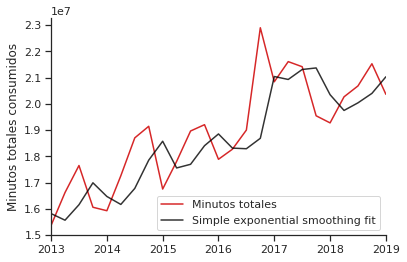

In [29]:
fig, ax= plt.subplots();#figsize=(9,6))
df['total'].plot(color=red, label='Minutos totales')
fitted_ses.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Minutos totales consumidos')
ax.set_title('')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

#### Análisis de resultados

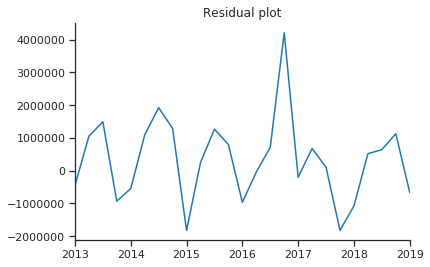

In [31]:
resid = df['total'] - fitted_ses 
fig, ax= plt.subplots();#figsize=(9,6))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

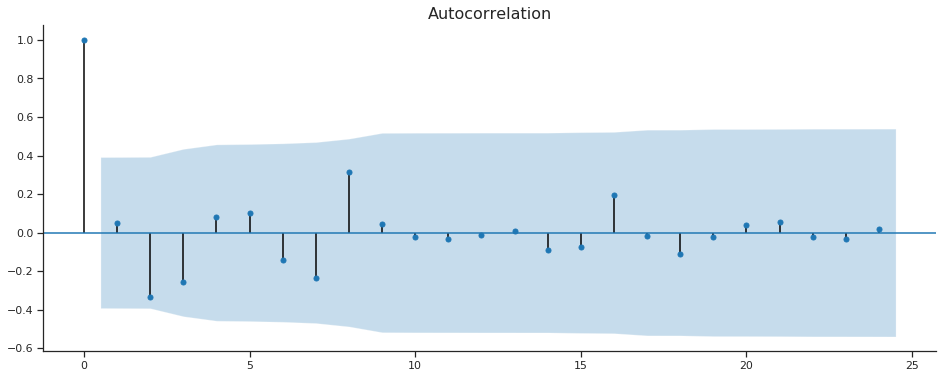

In [34]:
fig, ax = plt.subplots(figsize = (16, 6))
sm.graphics.tsa.plot_acf(resid, lags = 24, ax = ax)
ax.set_title('Autocorrelation', fontsize = 16)
sns.despine()
plt.show()

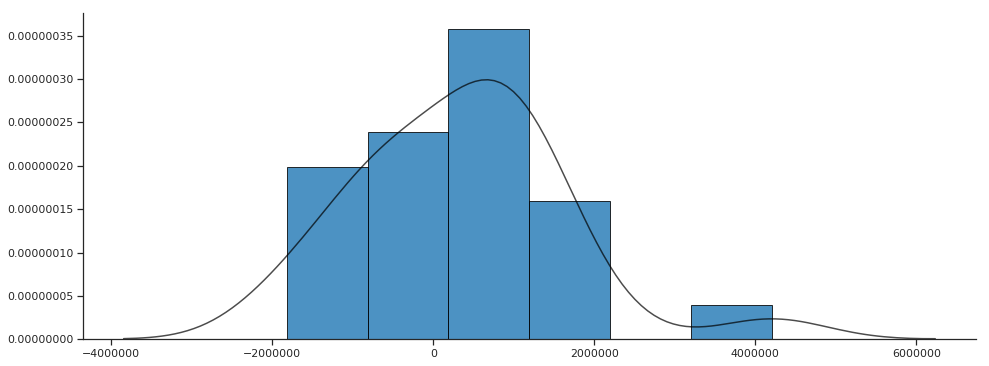

In [35]:
def hist(series):
    fig, ax = plt.subplots(figsize = (16, 6))
    plt.ticklabel_format(style = 'plain')
    
    sns.distplot(series, ax = ax, hist_kws = {'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws = {'color': 'black', 'alpha': 0.7})
    
    sns.despine()
    return fig, ax

hist(resid)
plt.show()

#### Validación del modelo

In [38]:
validation = df['total']['2014Q1':].index # the validation period is Q1 2014 onwards
start = df['total'].index.get_loc('2014Q1') # numerical index corresponding to Q1 2015

pred1 = []
pred2 = []
actual= []
for i in range(start, len(df['total'])):
    
    actual.append(df['total'].iloc[i]) # actual value
    
    pred1.append(df['total'].iloc[i-1]) # random walk forecast
    
    model = sm.tsa.SimpleExpSmoothing(df['total'].astype(float).iloc[:i]).fit() 
    pred2.append(model.forecast(1)[0]) # SES forecast

columns=['RW', 'SES', 'Actual']
results_sm = np.vstack([pred1, pred2, actual]).T
results_sm = pd.DataFrame(results_sm, columns = columns, index = validation)
results_sm.tail()

/home/alain/miniconda3/envs/diplo/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


,RW,SES,Actual
2018Q1,19545262.0,2.036284e+07,19274565.0
2018Q2,19274565.0,1.967908e+07,20267591.0
2018Q3,20267591.0,2.003145e+07,20682782.0
2018Q4,20682782.0,2.041573e+07,21528745.0
2019Q1,21528745.0,2.113715e+07,20364355.0


In [39]:
from scipy import stats
table = pd.DataFrame(0.0, index = results_sm.columns[:-1], columns = ['RMSE', 'SE'])
for i in range(2):
    table.iloc[i, 0] = sm.tools.eval_measures.rmse(results_sm.iloc[:, i], results_sm.iloc[:, -1])
    table.iloc[i, 1] = (results_sm.iloc[:, i] - results_sm.iloc[:, -1]).sem()
    
table.round(3)

,RMSE,SE
RW,1407131.775,311288.345
SES,1505145.822,331214.132


#### Forecasting

In [40]:
h=12
w=h*10
data = df['total']
model = sm.tsa.SimpleExpSmoothing
pred_index = df['total'].index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_exp = None
orig_roll = None
for i in range(0,h):
    current_exp = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current_exp).fit()
    pred_expanding.update(expanding.forecast(1))
    current_roll = pd.concat([data, pred_rolling.head(i)])
    rolling = model(current_roll.tail(w)).fit()
    pred_rolling.update(rolling.forecast(1))
    if i==0:
        orig_fit = expanding.fittedvalues
        orig_roll = rolling.fittedvalues
ax = data[-w:].plot(color='red');#figsize=(9,6))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_roll[-w:],pred_rolling]).plot(ax=ax,color='green');

ValueError: Buffer dtype mismatch, expected 'double' but got 'long'